# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
import time

# wait_to_make = "trained_list/deberta-custom.txt"
# count = 0
# while 1:
#     if os.path.exists(wait_to_make):
#         break
#     print(f'sleep {count} h')
#     time.sleep(3600)
#     count+=1
    


In [2]:
EXP_NAME = "EleutherAI-gpt-neo-125M"


In [3]:
# !nvidia-smi

In [4]:
# ! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime

INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
dt_now = datetime.datetime.now()

date = dt_now.strftime('%Y-%m-%d-%H-%M-%S')
 
OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "EleutherAI/gpt-neo-125M"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=4
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [8]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [9]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [10]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.0
transformers.__version__: 4.16.2
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [12]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [13]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [14]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

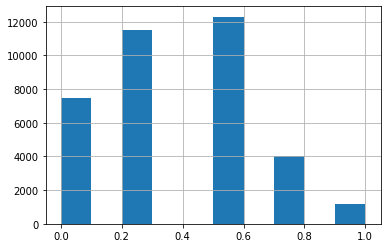

In [15]:
train['score'].hist()

In [16]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [17]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    12158
1    12158
2    12157
dtype: int64

In [18]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [19]:
# !pip install --no-cache-dir sentencepiece

In [20]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False, return_tensors="pt")
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = "[PAD]"
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



# Dataset

In [21]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 175


In [22]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [23]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [24]:
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size, 512),
#             nn.Tanh(),
#             nn.Linear(512, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
#         # feature = torch.mean(last_hidden_states, 1)
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         return output

In [25]:
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [26]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [27]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [28]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========


Some weights of GPTNeoModel were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['transformer.h.7.attn.attention.bias', 'transformer.h.3.attn.attention.bias', 'transformer.h.9.attn.attention.bias', 'transformer.h.11.attn.attention.bias', 'transformer.h.5.attn.attention.bias', 'transformer.h.1.attn.attention.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: [1][0/6078] Elapsed 0m 0s (remain 29m 32s) Loss: 1.0637(1.0637) Grad: inf  LR: 0.00002000  
Epoch: [1][100/6078] Elapsed 0m 11s (remain 11m 26s) Loss: 0.4433(0.7449) Grad: 81602.2266  LR: 0.00002000  
Epoch: [1][200/6078] Elapsed 0m 23s (remain 11m 21s) Loss: 0.7249(0.7043) Grad: 55054.8281  LR: 0.00002000  
Epoch: [1][300/6078] Elapsed 0m 34s (remain 11m 4s) Loss: 0.6113(0.6931) Grad: 32803.8828  LR: 0.00001999  
Epoch: [1][400/6078] Elapsed 0m 45s (remain 10m 49s) Loss: 0.5478(0.6833) Grad: 17377.4902  LR: 0.00001999  
Epoch: [1][500/6078] Elapsed 0m 57s (remain 10m 36s) Loss: 0.5814(0.6788) Grad: 33785.5977  LR: 0.00001998  
Epoch: [1][600/6078] Elapsed 1m 8s (remain 10m 23s) Loss: 0.7080(0.6714) Grad: 39240.1836  LR: 0.00001997  
Epoch: [1][700/6078] Elapsed 1m 19s (remain 10m 11s) Loss: 0.4683(0.6658) Grad: 18065.8496  LR: 0.00001996  
Epoch: [1][800/6078] Elapsed 1m 31s (remain 9m 59s) Loss: 0.8091(0.6622) Grad: 112673.3516  LR: 0.00001995  
Epoch: [1][900/6078] Elapsed 1m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/3040] Elapsed 0m 0s (remain 7m 11s) Loss: 0.5334(0.5334) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/3040] Elapsed 0m 2s (remain 1m 20s) Loss: 0.5154(0.5803) 
EVAL: [200/3040] Elapsed 0m 5s (remain 1m 15s) Loss: 0.6577(0.5639) 
EVAL: [300/3040] Elapsed 0m 7s (remain 1m 12s) Loss: 0.4354(0.5710) 
EVAL: [400/3040] Elapsed 0m 10s (remain 1m 9s) Loss: 0.5207(0.5680) 
EVAL: [500/3040] Elapsed 0m 13s (remain 1m 6s) Loss: 0.4263(0.5665) 
EVAL: [600/3040] Elapsed 0m 15s (remain 1m 4s) Loss: 0.6819(0.5660) 
EVAL: [700/3040] Elapsed 0m 18s (remain 1m 1s) Loss: 0.6174(0.5652) 
EVAL: [800/3040] Elapsed 0m 21s (remain 0m 58s) Loss: 0.4919(0.5634) 
EVAL: [900/3040] Elapsed 0m 23s (remain 0m 56s) Loss: 0.5816(0.5628) 
EVAL: [1000/3040] Elapsed 0m 26s (remain 0m 53s) Loss: 0.2961(0.5630) 
EVAL: [1100/3040] Elapsed 0m 28s (remain 0m 50s) Loss: 0.2366(0.5645) 
EVAL: [1200/3040] Elapsed 0m 31s (remain 0m 48s) Loss: 0.4983(0.5655) 
EVAL: [1300/3040] Elapsed 0m 34s (remain 0m 45s) Loss: 0.3748(0.5660) 
EVAL: [1400/3040] Elapsed 0m 36s (remain 0m 42s) Loss: 0.7502(0.5668) 
EVAL: [1500/3040] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 1 - avg_train_loss: 0.6032  avg_val_loss: 0.5676  time: 769s
Epoch 1 - Score: 0.7376
Epoch 1 - Save Best Score: 0.7376 Model


EVAL: [3039/3040] Elapsed 1m 19s (remain 0m 0s) Loss: 0.6401(0.5676) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/6078] Elapsed 0m 0s (remain 34m 49s) Loss: 0.4855(0.4855) Grad: inf  LR: 0.00001707  
Epoch: [2][100/6078] Elapsed 0m 11s (remain 11m 47s) Loss: 0.5342(0.5279) Grad: 30831.4316  LR: 0.00001698  
Epoch: [2][200/6078] Elapsed 0m 23s (remain 11m 32s) Loss: 0.5724(0.5333) Grad: 5970.8057  LR: 0.00001689  
Epoch: [2][300/6078] Elapsed 0m 35s (remain 11m 16s) Loss: 0.6235(0.5508) Grad: 33319.7383  LR: 0.00001679  
Epoch: [2][400/6078] Elapsed 0m 46s (remain 10m 58s) Loss: 0.6435(0.5518) Grad: 6491.2690  LR: 0.00001670  
Epoch: [2][500/6078] Elapsed 0m 57s (remain 10m 43s) Loss: 0.6144(0.5542) Grad: 27312.2266  LR: 0.00001660  
Epoch: [2][600/6078] Elapsed 1m 9s (remain 10m 29s) Loss: 0.1500(0.5524) Grad: 5990.4062  LR: 0.00001650  
Epoch: [2][700/6078] Elapsed 1m 20s (remain 10m 17s) Loss: 0.7640(0.5521) Grad: 33681.7344  LR: 0.00001640  
Epoch: [2][800/6078] Elapsed 1m 31s (remain 10m 4s) Loss: 0.5600(0.5509) Grad: 22290.3340  LR: 0.00001630  
Epoch: [2][900/6078] Elapsed 1m 43

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/3040] Elapsed 0m 0s (remain 6m 45s) Loss: 0.4999(0.4999) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/3040] Elapsed 0m 2s (remain 1m 19s) Loss: 0.5211(0.5717) 
EVAL: [200/3040] Elapsed 0m 5s (remain 1m 15s) Loss: 0.6933(0.5595) 
EVAL: [300/3040] Elapsed 0m 7s (remain 1m 12s) Loss: 0.6365(0.5665) 
EVAL: [400/3040] Elapsed 0m 10s (remain 1m 9s) Loss: 0.5167(0.5662) 
EVAL: [500/3040] Elapsed 0m 13s (remain 1m 6s) Loss: 0.4553(0.5620) 
EVAL: [600/3040] Elapsed 0m 15s (remain 1m 3s) Loss: 0.7057(0.5633) 
EVAL: [700/3040] Elapsed 0m 18s (remain 1m 1s) Loss: 0.6412(0.5638) 
EVAL: [800/3040] Elapsed 0m 20s (remain 0m 58s) Loss: 0.5138(0.5616) 
EVAL: [900/3040] Elapsed 0m 23s (remain 0m 55s) Loss: 0.5532(0.5612) 
EVAL: [1000/3040] Elapsed 0m 26s (remain 0m 53s) Loss: 0.2842(0.5617) 
EVAL: [1100/3040] Elapsed 0m 28s (remain 0m 50s) Loss: 0.2334(0.5639) 
EVAL: [1200/3040] Elapsed 0m 31s (remain 0m 48s) Loss: 0.4527(0.5654) 
EVAL: [1300/3040] Elapsed 0m 33s (remain 0m 45s) Loss: 0.3204(0.5659) 
EVAL: [1400/3040] Elapsed 0m 36s (remain 0m 42s) Loss: 0.7448(0.5671) 
EVAL: [1500/3040] Elap

Epoch 2 - avg_train_loss: 0.5542  avg_val_loss: 0.5671  time: 767s
Epoch 2 - Score: 0.7604
Epoch 2 - Save Best Score: 0.7604 Model


EVAL: [3039/3040] Elapsed 1m 19s (remain 0m 0s) Loss: 0.6360(0.5671) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/6078] Elapsed 0m 0s (remain 31m 23s) Loss: 0.5104(0.5104) Grad: 143535.1250  LR: 0.00001000  
Epoch: [3][100/6078] Elapsed 0m 11s (remain 11m 24s) Loss: 0.4603(0.5432) Grad: 17369.9062  LR: 0.00000987  
Epoch: [3][200/6078] Elapsed 0m 22s (remain 11m 8s) Loss: 0.5971(0.5273) Grad: 8334.7168  LR: 0.00000974  
Epoch: [3][300/6078] Elapsed 0m 34s (remain 10m 55s) Loss: 0.3176(0.5190) Grad: 160379.2656  LR: 0.00000961  
Epoch: [3][400/6078] Elapsed 0m 45s (remain 10m 43s) Loss: 0.5881(0.5210) Grad: 27153.7539  LR: 0.00000948  
Epoch: [3][500/6078] Elapsed 0m 56s (remain 10m 31s) Loss: 0.6482(0.5234) Grad: 81016.8516  LR: 0.00000936  
Epoch: [3][600/6078] Elapsed 1m 7s (remain 10m 19s) Loss: 0.3334(0.5224) Grad: 92837.2812  LR: 0.00000923  
Epoch: [3][700/6078] Elapsed 1m 19s (remain 10m 7s) Loss: 0.6151(0.5238) Grad: 12356.8574  LR: 0.00000910  
Epoch: [3][800/6078] Elapsed 1m 30s (remain 9m 56s) Loss: 0.5009(0.5230) Grad: 20712.0332  LR: 0.00000897  
Epoch: [3][900/6078] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/3040] Elapsed 0m 0s (remain 7m 14s) Loss: 0.5058(0.5058) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/3040] Elapsed 0m 2s (remain 1m 19s) Loss: 0.5218(0.6123) 
EVAL: [200/3040] Elapsed 0m 5s (remain 1m 15s) Loss: 0.6865(0.5928) 
EVAL: [300/3040] Elapsed 0m 7s (remain 1m 12s) Loss: 0.8378(0.5994) 
EVAL: [400/3040] Elapsed 0m 10s (remain 1m 9s) Loss: 0.5073(0.5941) 
EVAL: [500/3040] Elapsed 0m 13s (remain 1m 6s) Loss: 0.4533(0.5892) 
EVAL: [600/3040] Elapsed 0m 15s (remain 1m 3s) Loss: 0.6826(0.5874) 
EVAL: [700/3040] Elapsed 0m 18s (remain 1m 1s) Loss: 0.6243(0.5892) 
EVAL: [800/3040] Elapsed 0m 20s (remain 0m 58s) Loss: 0.5076(0.5863) 
EVAL: [900/3040] Elapsed 0m 23s (remain 0m 55s) Loss: 0.5410(0.5852) 
EVAL: [1000/3040] Elapsed 0m 26s (remain 0m 53s) Loss: 0.2829(0.5852) 
EVAL: [1100/3040] Elapsed 0m 28s (remain 0m 50s) Loss: 0.2016(0.5873) 
EVAL: [1200/3040] Elapsed 0m 31s (remain 0m 48s) Loss: 0.4332(0.5886) 
EVAL: [1300/3040] Elapsed 0m 33s (remain 0m 45s) Loss: 0.3156(0.5912) 
EVAL: [1400/3040] Elapsed 0m 36s (remain 0m 42s) Loss: 0.7342(0.5918) 
EVAL: [1500/3040] Elap

Epoch 3 - avg_train_loss: 0.5228  avg_val_loss: 0.5918  time: 765s
Epoch 3 - Score: 0.7600


EVAL: [3039/3040] Elapsed 1m 19s (remain 0m 0s) Loss: 0.6297(0.5918) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/6078] Elapsed 0m 0s (remain 20m 57s) Loss: 0.4595(0.4595) Grad: 106704.3750  LR: 0.00000293  
Epoch: [4][100/6078] Elapsed 0m 11s (remain 11m 15s) Loss: 0.6313(0.4972) Grad: 12554.4482  LR: 0.00000284  
Epoch: [4][200/6078] Elapsed 0m 22s (remain 11m 3s) Loss: 0.6498(0.5039) Grad: 31176.5488  LR: 0.00000275  
Epoch: [4][300/6078] Elapsed 0m 33s (remain 10m 51s) Loss: 0.4484(0.5012) Grad: 39875.2969  LR: 0.00000266  
Epoch: [4][400/6078] Elapsed 0m 45s (remain 10m 40s) Loss: 0.4250(0.5068) Grad: 18521.4297  LR: 0.00000257  
Epoch: [4][500/6078] Elapsed 0m 56s (remain 10m 28s) Loss: 0.6006(0.5127) Grad: 9660.7686  LR: 0.00000249  
Epoch: [4][600/6078] Elapsed 1m 7s (remain 10m 17s) Loss: 0.4911(0.5108) Grad: 5285.7656  LR: 0.00000240  
Epoch: [4][700/6078] Elapsed 1m 19s (remain 10m 6s) Loss: 0.6332(0.5118) Grad: 9159.4170  LR: 0.00000232  
Epoch: [4][800/6078] Elapsed 1m 30s (remain 9m 54s) Loss: 0.3187(0.5127) Grad: 5071.3281  LR: 0.00000224  
Epoch: [4][900/6078] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/3040] Elapsed 0m 0s (remain 6m 55s) Loss: 0.5086(0.5086) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/3040] Elapsed 0m 2s (remain 1m 19s) Loss: 0.5178(0.6414) 
EVAL: [200/3040] Elapsed 0m 5s (remain 1m 15s) Loss: 0.6909(0.6171) 
EVAL: [300/3040] Elapsed 0m 7s (remain 1m 12s) Loss: 0.8851(0.6195) 
EVAL: [400/3040] Elapsed 0m 10s (remain 1m 9s) Loss: 0.5059(0.6150) 
EVAL: [500/3040] Elapsed 0m 13s (remain 1m 6s) Loss: 0.4053(0.6105) 
EVAL: [600/3040] Elapsed 0m 15s (remain 1m 3s) Loss: 0.6892(0.6071) 
EVAL: [700/3040] Elapsed 0m 18s (remain 1m 1s) Loss: 0.6266(0.6090) 
EVAL: [800/3040] Elapsed 0m 20s (remain 0m 58s) Loss: 0.5015(0.6058) 
EVAL: [900/3040] Elapsed 0m 23s (remain 0m 55s) Loss: 0.5412(0.6035) 
EVAL: [1000/3040] Elapsed 0m 26s (remain 0m 53s) Loss: 0.2833(0.6025) 
EVAL: [1100/3040] Elapsed 0m 28s (remain 0m 50s) Loss: 0.1552(0.6043) 
EVAL: [1200/3040] Elapsed 0m 31s (remain 0m 48s) Loss: 0.4571(0.6053) 
EVAL: [1300/3040] Elapsed 0m 33s (remain 0m 45s) Loss: 0.3156(0.6082) 
EVAL: [1400/3040] Elapsed 0m 36s (remain 0m 42s) Loss: 0.7174(0.6083) 
EVAL: [1500/3040] Elap

Epoch 4 - avg_train_loss: 0.5085  avg_val_loss: 0.6083  time: 764s
Epoch 4 - Score: 0.7585


EVAL: [3039/3040] Elapsed 1m 19s (remain 0m 0s) Loss: 0.6280(0.6083) 


========== fold: 0 result ==========
Score: 0.7604
========== fold: 1 training ==========


========== fold: 1 training ==========


Some weights of GPTNeoModel were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['transformer.h.7.attn.attention.bias', 'transformer.h.3.attn.attention.bias', 'transformer.h.9.attn.attention.bias', 'transformer.h.11.attn.attention.bias', 'transformer.h.5.attn.attention.bias', 'transformer.h.1.attn.attention.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][0/6078] Elapsed 0m 0s (remain 42m 20s) Loss: 0.7815(0.7815) Grad: inf  LR: 0.00002000  
Epoch: [1][100/6078] Elapsed 0m 11s (remain 11m 25s) Loss: 0.5547(0.7269) Grad: 50282.8750  LR: 0.00002000  
Epoch: [1][200/6078] Elapsed 0m 22s (remain 11m 8s) Loss: 0.5289(0.7020) Grad: 35927.1797  LR: 0.00002000  
Epoch: [1][300/6078] Elapsed 0m 34s (remain 10m 55s) Loss: 0.6732(0.6950) Grad: 20661.1953  LR: 0.00001999  
Epoch: [1][400/6078] Elapsed 0m 45s (remain 10m 42s) Loss: 0.6544(0.6873) Grad: 67086.1953  LR: 0.00001999  
Epoch: [1][500/6078] Elapsed 0m 56s (remain 10m 30s) Loss: 0.6386(0.6795) Grad: 18212.9238  LR: 0.00001998  
Epoch: [1][600/6078] Elapsed 1m 7s (remain 10m 19s) Loss: 0.4516(0.6723) Grad: 40025.4609  LR: 0.00001997  
Epoch: [1][700/6078] Elapsed 1m 19s (remain 10m 7s) Loss: 0.8259(0.6678) Grad: 62452.3125  LR: 0.00001996  
Epoch: [1][800/6078] Elapsed 1m 30s (remain 9m 56s) Loss: 0.7953(0.6640) Grad: 31346.2148  LR: 0.00001995  
Epoch: [1][900/6078] Elapsed 1m 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/3040] Elapsed 0m 0s (remain 7m 15s) Loss: 0.6678(0.6678) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/3040] Elapsed 0m 2s (remain 1m 19s) Loss: 0.4943(0.5581) 
EVAL: [200/3040] Elapsed 0m 5s (remain 1m 15s) Loss: 0.4508(0.5650) 
EVAL: [300/3040] Elapsed 0m 7s (remain 1m 12s) Loss: 0.6811(0.5650) 
EVAL: [400/3040] Elapsed 0m 10s (remain 1m 9s) Loss: 0.6231(0.5678) 
EVAL: [500/3040] Elapsed 0m 13s (remain 1m 6s) Loss: 0.4729(0.5684) 
EVAL: [600/3040] Elapsed 0m 15s (remain 1m 3s) Loss: 0.6940(0.5686) 
EVAL: [700/3040] Elapsed 0m 18s (remain 1m 1s) Loss: 1.0030(0.5722) 
EVAL: [800/3040] Elapsed 0m 20s (remain 0m 58s) Loss: 0.5786(0.5726) 
EVAL: [900/3040] Elapsed 0m 23s (remain 0m 55s) Loss: 0.6689(0.5761) 
EVAL: [1000/3040] Elapsed 0m 26s (remain 0m 53s) Loss: 0.3792(0.5748) 
EVAL: [1100/3040] Elapsed 0m 28s (remain 0m 50s) Loss: 0.8263(0.5746) 
EVAL: [1200/3040] Elapsed 0m 31s (remain 0m 48s) Loss: 0.7347(0.5732) 
EVAL: [1300/3040] Elapsed 0m 33s (remain 0m 45s) Loss: 0.6144(0.5733) 
EVAL: [1400/3040] Elapsed 0m 36s (remain 0m 42s) Loss: 0.6141(0.5743) 
EVAL: [1500/3040] Elap

Epoch 1 - avg_train_loss: 0.6047  avg_val_loss: 0.5707  time: 765s
Epoch 1 - Score: 0.7301
Epoch 1 - Save Best Score: 0.7301 Model


EVAL: [3039/3040] Elapsed 1m 19s (remain 0m 0s) Loss: 0.7145(0.5707) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/6078] Elapsed 0m 0s (remain 32m 3s) Loss: 0.6038(0.6038) Grad: inf  LR: 0.00001707  
Epoch: [2][100/6078] Elapsed 0m 11s (remain 11m 25s) Loss: 0.6631(0.5796) Grad: 9248.4092  LR: 0.00001698  
Epoch: [2][200/6078] Elapsed 0m 22s (remain 11m 8s) Loss: 0.6681(0.5778) Grad: 21880.3477  LR: 0.00001689  
Epoch: [2][300/6078] Elapsed 0m 34s (remain 10m 55s) Loss: 0.5161(0.5724) Grad: 66556.8516  LR: 0.00001679  
Epoch: [2][400/6078] Elapsed 0m 45s (remain 10m 43s) Loss: 0.5327(0.5719) Grad: 64471.0391  LR: 0.00001670  
Epoch: [2][500/6078] Elapsed 0m 56s (remain 10m 31s) Loss: 0.6033(0.5669) Grad: 18520.0137  LR: 0.00001660  
Epoch: [2][600/6078] Elapsed 1m 8s (remain 10m 19s) Loss: 0.6126(0.5651) Grad: 23073.0840  LR: 0.00001650  
Epoch: [2][700/6078] Elapsed 1m 19s (remain 10m 8s) Loss: 0.5427(0.5629) Grad: 50817.1211  LR: 0.00001640  
Epoch: [2][800/6078] Elapsed 1m 30s (remain 9m 56s) Loss: 0.6839(0.5624) Grad: 47422.0898  LR: 0.00001630  
Epoch: [2][900/6078] Elapsed 1m 41s

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/3040] Elapsed 0m 0s (remain 7m 25s) Loss: 0.6612(0.6612) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/3040] Elapsed 0m 2s (remain 1m 19s) Loss: 0.4600(0.5592) 
EVAL: [200/3040] Elapsed 0m 5s (remain 1m 15s) Loss: 0.5271(0.5607) 
EVAL: [300/3040] Elapsed 0m 7s (remain 1m 12s) Loss: 0.6853(0.5591) 
EVAL: [400/3040] Elapsed 0m 10s (remain 1m 9s) Loss: 0.6385(0.5599) 
EVAL: [500/3040] Elapsed 0m 13s (remain 1m 6s) Loss: 0.4581(0.5599) 
EVAL: [600/3040] Elapsed 0m 15s (remain 1m 3s) Loss: 0.6701(0.5604) 
EVAL: [700/3040] Elapsed 0m 18s (remain 1m 1s) Loss: 0.7853(0.5636) 
EVAL: [800/3040] Elapsed 0m 20s (remain 0m 58s) Loss: 0.5816(0.5651) 
EVAL: [900/3040] Elapsed 0m 23s (remain 0m 55s) Loss: 0.6656(0.5675) 
EVAL: [1000/3040] Elapsed 0m 26s (remain 0m 53s) Loss: 0.3691(0.5680) 
EVAL: [1100/3040] Elapsed 0m 28s (remain 0m 50s) Loss: 0.8092(0.5674) 
EVAL: [1200/3040] Elapsed 0m 31s (remain 0m 48s) Loss: 0.7338(0.5662) 
EVAL: [1300/3040] Elapsed 0m 33s (remain 0m 45s) Loss: 0.6312(0.5668) 
EVAL: [1400/3040] Elapsed 0m 36s (remain 0m 42s) Loss: 0.6112(0.5675) 
EVAL: [1500/3040] Elap

Epoch 2 - avg_train_loss: 0.5582  avg_val_loss: 0.5639  time: 765s
Epoch 2 - Score: 0.7576
Epoch 2 - Save Best Score: 0.7576 Model


EVAL: [3039/3040] Elapsed 1m 19s (remain 0m 0s) Loss: 0.7424(0.5639) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/6078] Elapsed 0m 0s (remain 34m 1s) Loss: 0.7706(0.7706) Grad: inf  LR: 0.00001000  
Epoch: [3][100/6078] Elapsed 0m 11s (remain 11m 26s) Loss: 0.6761(0.5347) Grad: 35430.4336  LR: 0.00000987  
Epoch: [3][200/6078] Elapsed 0m 22s (remain 11m 7s) Loss: 0.6816(0.5334) Grad: 32593.2695  LR: 0.00000974  
Epoch: [3][300/6078] Elapsed 0m 34s (remain 10m 54s) Loss: 0.3287(0.5259) Grad: 19596.1914  LR: 0.00000961  
Epoch: [3][400/6078] Elapsed 0m 45s (remain 10m 42s) Loss: 0.4094(0.5293) Grad: 53163.9062  LR: 0.00000948  
Epoch: [3][500/6078] Elapsed 0m 56s (remain 10m 30s) Loss: 0.4686(0.5283) Grad: 42306.6562  LR: 0.00000936  
Epoch: [3][600/6078] Elapsed 1m 7s (remain 10m 19s) Loss: 0.6038(0.5276) Grad: 57902.6953  LR: 0.00000923  
Epoch: [3][700/6078] Elapsed 1m 19s (remain 10m 7s) Loss: 0.7351(0.5287) Grad: 216584.8438  LR: 0.00000910  
Epoch: [3][800/6078] Elapsed 1m 30s (remain 9m 56s) Loss: 0.4357(0.5273) Grad: 15885.8926  LR: 0.00000897  
Epoch: [3][900/6078] Elapsed 1m 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/3040] Elapsed 0m 0s (remain 7m 32s) Loss: 0.6574(0.6574) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/3040] Elapsed 0m 2s (remain 1m 20s) Loss: 0.4165(0.5823) 
EVAL: [200/3040] Elapsed 0m 5s (remain 1m 15s) Loss: 0.4950(0.5845) 
EVAL: [300/3040] Elapsed 0m 7s (remain 1m 12s) Loss: 0.6602(0.5790) 
EVAL: [400/3040] Elapsed 0m 10s (remain 1m 9s) Loss: 0.6414(0.5798) 
EVAL: [500/3040] Elapsed 0m 13s (remain 1m 6s) Loss: 0.5126(0.5846) 
EVAL: [600/3040] Elapsed 0m 15s (remain 1m 4s) Loss: 0.6541(0.5837) 
EVAL: [700/3040] Elapsed 0m 18s (remain 1m 1s) Loss: 1.0787(0.5870) 
EVAL: [800/3040] Elapsed 0m 21s (remain 0m 58s) Loss: 0.8540(0.5888) 
EVAL: [900/3040] Elapsed 0m 23s (remain 0m 56s) Loss: 0.6674(0.5913) 
EVAL: [1000/3040] Elapsed 0m 26s (remain 0m 53s) Loss: 0.5379(0.5911) 
EVAL: [1100/3040] Elapsed 0m 28s (remain 0m 50s) Loss: 0.7703(0.5903) 
EVAL: [1200/3040] Elapsed 0m 31s (remain 0m 48s) Loss: 0.7256(0.5890) 
EVAL: [1300/3040] Elapsed 0m 34s (remain 0m 45s) Loss: 0.6338(0.5892) 
EVAL: [1400/3040] Elapsed 0m 36s (remain 0m 42s) Loss: 0.6103(0.5892) 
EVAL: [1500/3040] Elap

Epoch 3 - avg_train_loss: 0.5249  avg_val_loss: 0.5815  time: 768s
Epoch 3 - Score: 0.7637
Epoch 3 - Save Best Score: 0.7637 Model


EVAL: [3039/3040] Elapsed 1m 19s (remain 0m 0s) Loss: 0.7254(0.5815) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/6078] Elapsed 0m 0s (remain 32m 45s) Loss: 0.5020(0.5020) Grad: 150836.6094  LR: 0.00000293  
Epoch: [4][100/6078] Elapsed 0m 11s (remain 11m 28s) Loss: 0.2942(0.5091) Grad: 22967.1191  LR: 0.00000284  
Epoch: [4][200/6078] Elapsed 0m 22s (remain 11m 8s) Loss: 0.1707(0.5078) Grad: 11657.2744  LR: 0.00000275  
Epoch: [4][300/6078] Elapsed 0m 34s (remain 10m 55s) Loss: 0.4551(0.5068) Grad: 16387.2812  LR: 0.00000266  
Epoch: [4][400/6078] Elapsed 0m 45s (remain 10m 43s) Loss: 0.3853(0.5114) Grad: 17041.6230  LR: 0.00000257  
Epoch: [4][500/6078] Elapsed 0m 56s (remain 10m 32s) Loss: 0.4685(0.5117) Grad: 8147.4004  LR: 0.00000249  
Epoch: [4][600/6078] Elapsed 1m 8s (remain 10m 20s) Loss: 0.5979(0.5109) Grad: 2921.1741  LR: 0.00000240  
Epoch: [4][700/6078] Elapsed 1m 19s (remain 10m 9s) Loss: 0.2347(0.5084) Grad: 10563.2559  LR: 0.00000232  
Epoch: [4][800/6078] Elapsed 1m 30s (remain 9m 57s) Loss: 0.5284(0.5091) Grad: 4841.8916  LR: 0.00000224  
Epoch: [4][900/6078] Elapsed

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][6077/6078] Elapsed 11m 25s (remain 0m 0s) Loss: 0.6036(0.5108) Grad: 4503.1841  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/3040] Elapsed 0m 0s (remain 7m 15s) Loss: 0.6518(0.6518) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/3040] Elapsed 0m 2s (remain 1m 19s) Loss: 0.4170(0.5932) 
EVAL: [200/3040] Elapsed 0m 5s (remain 1m 15s) Loss: 0.5229(0.5946) 
EVAL: [300/3040] Elapsed 0m 7s (remain 1m 12s) Loss: 0.6549(0.5884) 
EVAL: [400/3040] Elapsed 0m 10s (remain 1m 9s) Loss: 0.6503(0.5896) 
EVAL: [500/3040] Elapsed 0m 13s (remain 1m 6s) Loss: 0.4956(0.5958) 
EVAL: [600/3040] Elapsed 0m 15s (remain 1m 3s) Loss: 0.6450(0.5943) 
EVAL: [700/3040] Elapsed 0m 18s (remain 1m 1s) Loss: 1.1712(0.5979) 
EVAL: [800/3040] Elapsed 0m 20s (remain 0m 58s) Loss: 0.9322(0.6004) 
EVAL: [900/3040] Elapsed 0m 23s (remain 0m 55s) Loss: 0.6684(0.6028) 
EVAL: [1000/3040] Elapsed 0m 26s (remain 0m 53s) Loss: 0.6325(0.6028) 
EVAL: [1100/3040] Elapsed 0m 28s (remain 0m 50s) Loss: 0.7480(0.6016) 
EVAL: [1200/3040] Elapsed 0m 31s (remain 0m 48s) Loss: 0.7293(0.6008) 
EVAL: [1300/3040] Elapsed 0m 33s (remain 0m 45s) Loss: 0.6355(0.6021) 
EVAL: [1400/3040] Elapsed 0m 36s (remain 0m 42s) Loss: 0.6120(0.6020) 
EVAL: [1500/3040] Elap

Epoch 4 - avg_train_loss: 0.5108  avg_val_loss: 0.5935  time: 765s
Epoch 4 - Score: 0.7614


EVAL: [3039/3040] Elapsed 1m 19s (remain 0m 0s) Loss: 0.7399(0.5935) 


========== fold: 1 result ==========
Score: 0.7637
========== fold: 2 training ==========


========== fold: 2 training ==========


Some weights of GPTNeoModel were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['transformer.h.7.attn.attention.bias', 'transformer.h.3.attn.attention.bias', 'transformer.h.9.attn.attention.bias', 'transformer.h.11.attn.attention.bias', 'transformer.h.5.attn.attention.bias', 'transformer.h.1.attn.attention.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][0/6079] Elapsed 0m 0s (remain 40m 12s) Loss: 0.6622(0.6622) Grad: inf  LR: 0.00002000  
Epoch: [1][100/6079] Elapsed 0m 11s (remain 11m 24s) Loss: 0.7217(0.7071) Grad: 27403.7656  LR: 0.00002000  
Epoch: [1][200/6079] Elapsed 0m 22s (remain 11m 7s) Loss: 0.7319(0.6959) Grad: 64405.0703  LR: 0.00002000  
Epoch: [1][300/6079] Elapsed 0m 34s (remain 10m 54s) Loss: 0.5375(0.6901) Grad: 43580.1836  LR: 0.00001999  
Epoch: [1][400/6079] Elapsed 0m 45s (remain 10m 42s) Loss: 0.5600(0.6769) Grad: 16801.3926  LR: 0.00001999  
Epoch: [1][500/6079] Elapsed 0m 56s (remain 10m 30s) Loss: 0.7437(0.6630) Grad: 24530.9512  LR: 0.00001998  
Epoch: [1][600/6079] Elapsed 1m 7s (remain 10m 19s) Loss: 0.5609(0.6568) Grad: 29814.5840  LR: 0.00001997  
Epoch: [1][700/6079] Elapsed 1m 19s (remain 10m 7s) Loss: 0.5983(0.6577) Grad: 37370.3516  LR: 0.00001996  
Epoch: [1][800/6079] Elapsed 1m 30s (remain 9m 56s) Loss: 0.5634(0.6547) Grad: 33059.5430  LR: 0.00001995  
Epoch: [1][900/6079] Elapsed 1m 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][6078/6079] Elapsed 11m 25s (remain 0m 0s) Loss: 0.5634(0.6012) Grad: 25196.1406  LR: 0.00001707  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/3040] Elapsed 0m 0s (remain 7m 30s) Loss: 0.6629(0.6629) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/3040] Elapsed 0m 2s (remain 1m 20s) Loss: 0.6350(0.5613) 
EVAL: [200/3040] Elapsed 0m 5s (remain 1m 15s) Loss: 0.5028(0.5727) 
EVAL: [300/3040] Elapsed 0m 7s (remain 1m 12s) Loss: 0.4398(0.5715) 
EVAL: [400/3040] Elapsed 0m 10s (remain 1m 9s) Loss: 0.5510(0.5717) 
EVAL: [500/3040] Elapsed 0m 13s (remain 1m 6s) Loss: 0.7903(0.5764) 
EVAL: [600/3040] Elapsed 0m 15s (remain 1m 3s) Loss: 0.3207(0.5765) 
EVAL: [700/3040] Elapsed 0m 18s (remain 1m 1s) Loss: 0.5118(0.5734) 
EVAL: [800/3040] Elapsed 0m 20s (remain 0m 58s) Loss: 0.5349(0.5725) 
EVAL: [900/3040] Elapsed 0m 23s (remain 0m 55s) Loss: 0.6593(0.5724) 
EVAL: [1000/3040] Elapsed 0m 26s (remain 0m 53s) Loss: 0.5368(0.5748) 
EVAL: [1100/3040] Elapsed 0m 28s (remain 0m 50s) Loss: 0.3501(0.5741) 
EVAL: [1200/3040] Elapsed 0m 31s (remain 0m 48s) Loss: 0.3588(0.5736) 
EVAL: [1300/3040] Elapsed 0m 33s (remain 0m 45s) Loss: 0.6518(0.5725) 
EVAL: [1400/3040] Elapsed 0m 36s (remain 0m 42s) Loss: 0.5466(0.5721) 
EVAL: [1500/3040] Elap

Epoch 1 - avg_train_loss: 0.6012  avg_val_loss: 0.5765  time: 765s
Epoch 1 - Score: 0.7200
Epoch 1 - Save Best Score: 0.7200 Model


EVAL: [3039/3040] Elapsed 1m 19s (remain 0m 0s) Loss: 1.1313(0.5765) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/6079] Elapsed 0m 0s (remain 33m 30s) Loss: 0.4600(0.4600) Grad: 79333.8359  LR: 0.00001707  
Epoch: [2][100/6079] Elapsed 0m 11s (remain 11m 22s) Loss: 0.5307(0.5478) Grad: 16440.6504  LR: 0.00001698  
Epoch: [2][200/6079] Elapsed 0m 22s (remain 11m 7s) Loss: 0.4717(0.5498) Grad: 10780.4561  LR: 0.00001689  
Epoch: [2][300/6079] Elapsed 0m 34s (remain 10m 54s) Loss: 0.4542(0.5494) Grad: 21673.8301  LR: 0.00001679  
Epoch: [2][400/6079] Elapsed 0m 45s (remain 10m 42s) Loss: 0.4576(0.5502) Grad: 2171.0986  LR: 0.00001670  
Epoch: [2][500/6079] Elapsed 0m 56s (remain 10m 30s) Loss: 0.4763(0.5516) Grad: 14984.6924  LR: 0.00001660  
Epoch: [2][600/6079] Elapsed 1m 7s (remain 10m 19s) Loss: 0.3355(0.5545) Grad: 23213.8184  LR: 0.00001650  
Epoch: [2][700/6079] Elapsed 1m 19s (remain 10m 7s) Loss: 0.5326(0.5537) Grad: 10105.5771  LR: 0.00001640  
Epoch: [2][800/6079] Elapsed 1m 30s (remain 9m 56s) Loss: 0.5243(0.5585) Grad: 16147.2949  LR: 0.00001630  
Epoch: [2][900/6079] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/3040] Elapsed 0m 0s (remain 7m 39s) Loss: 0.6827(0.6827) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/3040] Elapsed 0m 2s (remain 1m 19s) Loss: 0.6398(0.5627) 
EVAL: [200/3040] Elapsed 0m 5s (remain 1m 15s) Loss: 0.5162(0.5883) 
EVAL: [300/3040] Elapsed 0m 7s (remain 1m 12s) Loss: 0.4330(0.5870) 
EVAL: [400/3040] Elapsed 0m 10s (remain 1m 9s) Loss: 0.5765(0.5905) 
EVAL: [500/3040] Elapsed 0m 13s (remain 1m 6s) Loss: 1.0147(0.5992) 
EVAL: [600/3040] Elapsed 0m 15s (remain 1m 3s) Loss: 0.3271(0.5989) 
EVAL: [700/3040] Elapsed 0m 18s (remain 1m 1s) Loss: 0.4929(0.5959) 
EVAL: [800/3040] Elapsed 0m 20s (remain 0m 58s) Loss: 0.4574(0.5969) 
EVAL: [900/3040] Elapsed 0m 23s (remain 0m 55s) Loss: 0.6476(0.5972) 
EVAL: [1000/3040] Elapsed 0m 26s (remain 0m 53s) Loss: 0.6481(0.5979) 
EVAL: [1100/3040] Elapsed 0m 28s (remain 0m 50s) Loss: 0.3551(0.5969) 
EVAL: [1200/3040] Elapsed 0m 31s (remain 0m 48s) Loss: 0.2949(0.5958) 
EVAL: [1300/3040] Elapsed 0m 33s (remain 0m 45s) Loss: 0.8551(0.5942) 
EVAL: [1400/3040] Elapsed 0m 36s (remain 0m 42s) Loss: 0.6156(0.5931) 
EVAL: [1500/3040] Elap

Epoch 2 - avg_train_loss: 0.5555  avg_val_loss: 0.5998  time: 765s
Epoch 2 - Score: 0.7465
Epoch 2 - Save Best Score: 0.7465 Model


EVAL: [3039/3040] Elapsed 1m 19s (remain 0m 0s) Loss: 0.8397(0.5998) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/6079] Elapsed 0m 0s (remain 41m 21s) Loss: 0.5733(0.5733) Grad: 244788.9375  LR: 0.00001000  
Epoch: [3][100/6079] Elapsed 0m 11s (remain 11m 27s) Loss: 0.4767(0.5216) Grad: 118820.1641  LR: 0.00000987  
Epoch: [3][200/6079] Elapsed 0m 22s (remain 11m 8s) Loss: 0.3671(0.5349) Grad: 22869.6816  LR: 0.00000974  
Epoch: [3][300/6079] Elapsed 0m 34s (remain 10m 55s) Loss: 0.4952(0.5368) Grad: 10982.8115  LR: 0.00000961  
Epoch: [3][400/6079] Elapsed 0m 45s (remain 10m 42s) Loss: 0.4400(0.5348) Grad: 11325.1729  LR: 0.00000948  
Epoch: [3][500/6079] Elapsed 0m 56s (remain 10m 31s) Loss: 0.6885(0.5312) Grad: 25668.7285  LR: 0.00000935  
Epoch: [3][600/6079] Elapsed 1m 7s (remain 10m 19s) Loss: 0.3314(0.5289) Grad: 23319.7520  LR: 0.00000922  
Epoch: [3][700/6079] Elapsed 1m 19s (remain 10m 7s) Loss: 0.4589(0.5277) Grad: 30877.9922  LR: 0.00000910  
Epoch: [3][800/6079] Elapsed 1m 30s (remain 9m 56s) Loss: 0.6263(0.5279) Grad: 26913.7773  LR: 0.00000897  
Epoch: [3][900/6079] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][6078/6079] Elapsed 11m 28s (remain 0m 0s) Loss: 0.6390(0.5243) Grad: 2434.9041  LR: 0.00000293  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/3040] Elapsed 0m 0s (remain 8m 18s) Loss: 0.6453(0.6453) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/3040] Elapsed 0m 2s (remain 1m 26s) Loss: 0.6520(0.5648) 
EVAL: [200/3040] Elapsed 0m 5s (remain 1m 20s) Loss: 0.5156(0.5721) 
EVAL: [300/3040] Elapsed 0m 8s (remain 1m 17s) Loss: 0.4559(0.5710) 
EVAL: [400/3040] Elapsed 0m 11s (remain 1m 13s) Loss: 0.5343(0.5712) 
EVAL: [500/3040] Elapsed 0m 13s (remain 1m 9s) Loss: 0.7959(0.5794) 
EVAL: [600/3040] Elapsed 0m 16s (remain 1m 6s) Loss: 0.3156(0.5793) 
EVAL: [700/3040] Elapsed 0m 18s (remain 1m 3s) Loss: 0.4337(0.5758) 
EVAL: [800/3040] Elapsed 0m 21s (remain 1m 0s) Loss: 0.5536(0.5771) 
EVAL: [900/3040] Elapsed 0m 24s (remain 0m 57s) Loss: 0.6972(0.5779) 
EVAL: [1000/3040] Elapsed 0m 26s (remain 0m 54s) Loss: 0.5581(0.5788) 
EVAL: [1100/3040] Elapsed 0m 29s (remain 0m 51s) Loss: 0.3475(0.5795) 
EVAL: [1200/3040] Elapsed 0m 32s (remain 0m 49s) Loss: 0.3304(0.5790) 
EVAL: [1300/3040] Elapsed 0m 34s (remain 0m 46s) Loss: 0.7979(0.5782) 
EVAL: [1400/3040] Elapsed 0m 37s (remain 0m 43s) Loss: 0.6315(0.5771) 
EVAL: [1500/3040] Elap

Epoch 3 - avg_train_loss: 0.5243  avg_val_loss: 0.5823  time: 769s
Epoch 3 - Score: 0.7649
Epoch 3 - Save Best Score: 0.7649 Model


EVAL: [3039/3040] Elapsed 1m 20s (remain 0m 0s) Loss: 0.6931(0.5823) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/6079] Elapsed 0m 0s (remain 40m 51s) Loss: 0.1913(0.1913) Grad: 350630.2812  LR: 0.00000293  
Epoch: [4][100/6079] Elapsed 0m 11s (remain 11m 30s) Loss: 0.3909(0.5010) Grad: 54856.7930  LR: 0.00000284  
Epoch: [4][200/6079] Elapsed 0m 22s (remain 11m 12s) Loss: 0.6604(0.5083) Grad: 72970.6562  LR: 0.00000275  
Epoch: [4][300/6079] Elapsed 0m 34s (remain 10m 58s) Loss: 0.5668(0.5108) Grad: 11801.9678  LR: 0.00000266  
Epoch: [4][400/6079] Elapsed 0m 45s (remain 10m 45s) Loss: 0.4915(0.5100) Grad: 6669.2637  LR: 0.00000257  
Epoch: [4][500/6079] Elapsed 0m 56s (remain 10m 33s) Loss: 0.3332(0.5105) Grad: 17075.9629  LR: 0.00000249  
Epoch: [4][600/6079] Elapsed 1m 8s (remain 10m 22s) Loss: 0.4034(0.5092) Grad: 51878.3867  LR: 0.00000240  
Epoch: [4][700/6079] Elapsed 1m 19s (remain 10m 10s) Loss: 0.6330(0.5088) Grad: 10598.2217  LR: 0.00000232  
Epoch: [4][800/6079] Elapsed 1m 30s (remain 9m 58s) Loss: 0.3201(0.5060) Grad: 9604.4688  LR: 0.00000224  
Epoch: [4][900/6079] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][6078/6079] Elapsed 11m 28s (remain 0m 0s) Loss: 0.6630(0.5077) Grad: 1939.4739  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/3040] Elapsed 0m 0s (remain 7m 50s) Loss: 0.6581(0.6581) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [100/3040] Elapsed 0m 2s (remain 1m 20s) Loss: 0.6506(0.5750) 
EVAL: [200/3040] Elapsed 0m 5s (remain 1m 15s) Loss: 0.5104(0.5822) 
EVAL: [300/3040] Elapsed 0m 7s (remain 1m 12s) Loss: 0.4536(0.5800) 
EVAL: [400/3040] Elapsed 0m 10s (remain 1m 9s) Loss: 0.5336(0.5806) 
EVAL: [500/3040] Elapsed 0m 13s (remain 1m 6s) Loss: 0.7893(0.5890) 
EVAL: [600/3040] Elapsed 0m 15s (remain 1m 4s) Loss: 0.3152(0.5896) 
EVAL: [700/3040] Elapsed 0m 18s (remain 1m 1s) Loss: 0.4492(0.5858) 
EVAL: [800/3040] Elapsed 0m 21s (remain 0m 58s) Loss: 0.5688(0.5874) 
EVAL: [900/3040] Elapsed 0m 23s (remain 0m 56s) Loss: 0.7022(0.5882) 
EVAL: [1000/3040] Elapsed 0m 26s (remain 0m 53s) Loss: 0.7116(0.5888) 
EVAL: [1100/3040] Elapsed 0m 28s (remain 0m 50s) Loss: 0.3478(0.5897) 
EVAL: [1200/3040] Elapsed 0m 31s (remain 0m 48s) Loss: 0.3252(0.5891) 
EVAL: [1300/3040] Elapsed 0m 34s (remain 0m 45s) Loss: 0.8796(0.5885) 
EVAL: [1400/3040] Elapsed 0m 36s (remain 0m 42s) Loss: 0.6264(0.5872) 
EVAL: [1500/3040] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 4 - avg_train_loss: 0.5077  avg_val_loss: 0.5946  time: 768s
Epoch 4 - Score: 0.7620


EVAL: [3039/3040] Elapsed 1m 19s (remain 0m 0s) Loss: 0.6943(0.5946) 


========== fold: 2 result ==========
Score: 0.7649
========== CV ==========
Score: 0.7607


In [29]:
print(f'{time.time()-start} hour')

9242.446928024292 hour


In [30]:
!touch trained_list/gpt-net.txt